In [2]:
#Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.metrics import roc_auc_score, log_loss
from sklearn.metrics import log_loss, roc_auc_score, brier_score_loss
import shap

import warnings
warnings.filterwarnings('ignore')

In [3]:
# Getting Data set
!pip install pybaseball
from pybaseball import statcast
df_raw = statcast(start_dt="2024-03-28", end_dt="2024-09-30")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 426.1/426.1 kB 10.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.5/410.5 kB 16.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 856.7/856.7 kB 34.2 MB/s eta 0:00:00
This is a large query, it may take a moment to complete


100%|██████████| 187/187 [03:44<00:00,  1.20s/it]


In [4]:
# Set the max_columns option to None to display all columns
pd.set_option('display.max_columns', None)
df_raw.head(1)

,pitch_type,game_date,release_speed,release_pos_x,release_pos_z,player_name,batter,pitcher,events,description,spin_dir,spin_rate_deprecated,break_angle_deprecated,break_length_deprecated,zone,des,game_type,stand,p_throws,home_team,away_team,type,hit_location,bb_type,balls,strikes,game_year,pfx_x,pfx_z,plate_x,plate_z,on_3b,on_2b,on_1b,outs_when_up,inning,inning_topbot,hc_x,hc_y,tfs_deprecated,tfs_zulu_deprecated,umpire,sv_id,vx0,vy0,vz0,ax,ay,az,sz_top,sz_bot,hit_distance_sc,launch_speed,launch_angle,effective_speed,release_spin_rate,release_extension,game_pk,fielder_2,fielder_3,fielder_4,fielder_5,fielder_6,fielder_7,fielder_8,fielder_9,release_pos_y,estimated_ba_using_speedangle,estimated_woba_using_speedangle,woba_value,woba_denom,babip_value,iso_value,launch_speed_angle,at_bat_number,pitch_number,pitch_name,home_score,away_score,bat_score,fld_score,post_away_score,post_home_score,post_bat_score,post_fld_score,if_fielding_alignment,of_fielding_alignment,spin_axis,delta_home_win_exp,delta_run_exp,bat_speed,swing_length,estimated_slg_using_speedangle,delta_pitcher_run_exp,hyper_speed,home_score_diff,bat_score_diff,home_win_exp,bat_win_exp,age_pit_legacy,age_bat_legacy,age_pit,age_bat,n_thruorder_pitcher,n_priorpa_thisgame_player_at_bat,pitcher_days_since_prev_game,batter_days_since_prev_game,pitcher_days_until_next_game,batter_days_until_next_game,api_break_z_with_gravity,api_break_x_arm,api_break_x_batter_in,arm_angle
199,FF,2024-09-30,97.4,-2.1,4.88,"Díaz, Edwin",518595,621242,field_out,hit_into_play,<NA>,<NA>,<NA>,<NA>,3,"Travis d'Arnaud grounds out, shortstop Francis...",R,R,R,ATL,NYM,X,6,ground_ball,2,2,2024,-0.96,0.99,0.67,3.0,<NA>,642201,<NA>,2,9,Bot,112.78,146.97,<NA>,<NA>,<NA>,<NA>,9.89341,-141.548522,-1.857108,-15.148286,30.423852,-18.544662,3.43,1.54,5,87.6,-30,99.9,2196,7.6,747139,682626,624413,657193,578428,596019,607043,621438,516782,52.91,0.049,0.052,0.0,1,0,0,2,82,5,4-Seam Fastball,7,8,7,8,8,7,7,8,Standard,Strategic,232,-0.142,-0.275,68.8,7.3,0.059,0.275,88.0,-1,-1,0.142,0.142,30,35,30,35,1,4,1,1,3,1,1.4,0.96,0.96,17.6


In [125]:
df_raw['description'].unique()

array(['hit_into_play', 'ball', 'swinging_strike', 'blocked_ball', 'foul',
       'called_strike', 'swinging_strike_blocked', 'hit_by_pitch',
       'foul_tip', 'foul_bunt', 'pitchout', 'missed_bunt',
       'bunt_foul_tip'], dtype=object)

In [127]:
# Select necessary features
df_features = df_raw[['player_name', 'stand', 'game_date', 'inning', 'at_bat_number', 'pitch_number', 'pitch_name', 'zone', 'balls', 'strikes', 'outs_when_up', 'on_1b', 'on_2b', 'on_3b', 'description']]

# Create the RISP column
df_features['RISP'] = (df_features['on_2b'].notna() | df_features['on_3b'].notna()).astype('int')

# Create the WHIFF column
df_features['WHIFF / Called Strike'] = df_features['description'].isin(['swinging_strike', 'swinging_strike_blocked', 'called_strike']).astype('int')

# Drop the on-base columns
df_features = df_features.drop(columns=['on_1b', 'on_2b', 'on_3b'])

# Sort the DataFrame
df_features = df_features.sort_values(by=['player_name', 'game_date', 'inning', 'at_bat_number', 'pitch_number'])

# Create the "prev" columns by shifting the respective columns down by 1
df_features['prev_pitch_name'] = df_features.groupby(['player_name', 'game_date', 'inning', 'at_bat_number'])['pitch_name'].shift(1)
df_features['prev_zone'] = df_features.groupby(['player_name', 'game_date', 'inning', 'at_bat_number'])['zone'].shift(1)

# Delete rows where pitch_number = 1
df_features = df_features[df_features['pitch_number'] != 1]

# Remove rows where pitch_name or prev_pitch_name has NaN values
df_features = df_features.dropna(subset=['pitch_name', 'prev_pitch_name'])

# Reorder columns and drop unnecessary columns.
df_features = df_features[['player_name', 'stand',
    'prev_pitch_name', 'pitch_name', 'prev_zone', 'zone', 'outs_when_up',
    'balls', 'strikes', 'RISP', 'WHIFF / Called Strike']]

In [128]:
# Display the resulting DataFrame
df_features.sample(5)

,player_name,stand,prev_pitch_name,pitch_name,prev_zone,zone,outs_when_up,balls,strikes,RISP,WHIFF / Called Strike
3433,"Muñoz, Andrés",R,Sinker,4-Seam Fastball,14,11,1,2,1,0,0
1546,"Leiter, Jack",L,Cutter,4-Seam Fastball,12,3,0,1,0,0,1
2248,"Kirby, George",R,Slider,Split-Finger,14,14,1,1,2,1,0
209,"Mize, Casey",R,4-Seam Fastball,Slider,11,14,1,1,1,0,1
1489,"Miller, Erik",R,Changeup,Changeup,9,7,0,0,2,0,1


In [129]:
def filter_player_and_stand(df, player_name, stand):

    # Filter the DataFrame for the specified player_name and stand
    filtered_df = df[(df['player_name'] == player_name) & (df['stand'] == stand)].drop(columns=['player_name', 'stand'])

    return filtered_df

## Testing with Tarik Skubal against right handed batters.

In [130]:
Skubal_df = filter_player_and_stand(df_features, 'Skubal, Tarik', 'R')
Skubal_df.head(5)

,prev_pitch_name,pitch_name,prev_zone,zone,outs_when_up,balls,strikes,RISP,WHIFF / Called Strike
2678,Changeup,Changeup,4,8,2,0,1,0,0
2489,4-Seam Fastball,Sinker,12,11,2,0,1,0,0
2424,Sinker,Changeup,11,13,2,1,1,0,0
2293,Changeup,4-Seam Fastball,13,11,2,2,1,0,0
2173,4-Seam Fastball,Changeup,13,13,0,1,0,0,0


In [131]:
# Define features (X) and target (y)
X = Skubal_df.drop(columns=['WHIFF / Called Strike'])  # Everything except the target
y = Skubal_df['WHIFF / Called Strike']  # Target variable (1 for whiff, 0 for contact)

# Split data: 70% train, 15% validation, 15% test
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

# Perform one-hot encoding on categorical columns
X_train = pd.get_dummies(X_train, columns=['prev_pitch_name', 'pitch_name']).astype('int')
X_val = pd.get_dummies(X_val, columns=['prev_pitch_name', 'pitch_name']).astype('int')
X_test = pd.get_dummies(X_test, columns=['prev_pitch_name', 'pitch_name']).astype('int')

In [132]:
X_train.head(5)

,prev_zone,zone,outs_when_up,balls,strikes,RISP,prev_pitch_name_4-Seam Fastball,prev_pitch_name_Changeup,prev_pitch_name_Knuckle Curve,prev_pitch_name_Sinker,prev_pitch_name_Slider,pitch_name_4-Seam Fastball,pitch_name_Changeup,pitch_name_Knuckle Curve,pitch_name_Sinker,pitch_name_Slider
913,8,8,2,1,2,0,0,1,0,0,0,0,1,0,0,0
1387,14,1,2,1,1,0,0,1,0,0,0,1,0,0,0,0
2057,13,8,0,2,0,0,0,1,0,0,0,1,0,0,0,0
2284,13,9,2,1,1,0,0,0,1,0,0,0,1,0,0,0
1147,13,12,0,1,0,0,0,0,0,0,1,0,1,0,0,0


In [177]:
# Initialize XGBoost classifier
model = xgb.XGBClassifier(
    objective='binary:logistic',  # Output probabilities
    eval_metric='logloss',        # Good for probability calibration
    use_label_encoder=False,
    n_estimators=100,
    learning_rate=0.1,
    max_depth=5,
    random_state=42,
    early_stopping_rounds=10
)

# Train the model
model.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=True)

# Predict probabilities on test set
y_pred_proba = model.predict_proba(X_test)[:, 1]  # Probability of whiff / called strike


[0]	validation_0-logloss:0.59164
[1]	validation_0-logloss:0.58886
[2]	validation_0-logloss:0.58674
[3]	validation_0-logloss:0.58543
[4]	validation_0-logloss:0.58578
[5]	validation_0-logloss:0.58448
[6]	validation_0-logloss:0.58503
[7]	validation_0-logloss:0.58444
[8]	validation_0-logloss:0.58498
[9]	validation_0-logloss:0.58407
[10]	validation_0-logloss:0.58450
[11]	validation_0-logloss:0.58409
[12]	validation_0-logloss:0.58374
[13]	validation_0-logloss:0.58386
[14]	validation_0-logloss:0.58393
[15]	validation_0-logloss:0.58398
[16]	validation_0-logloss:0.58468
[17]	validation_0-logloss:0.58592
[18]	validation_0-logloss:0.58579
[19]	validation_0-logloss:0.58657
[20]	validation_0-logloss:0.58697
[21]	validation_0-logloss:0.58731
[22]	validation_0-logloss:0.58841


In [178]:
# Log loss (lower is better)
print("Log Loss:", log_loss(y_test, y_pred_proba))

# ROC-AUC (higher is better)
print("ROC-AUC:", roc_auc_score(y_test, y_pred_proba))

# Brier Score (lower is better, measures probability calibration)
print("Brier Score:", brier_score_loss(y_test, y_pred_proba))

Log Loss: 0.5544659220619631
ROC-AUC: 0.6848013816925734
Brier Score: 0.1863501192642274


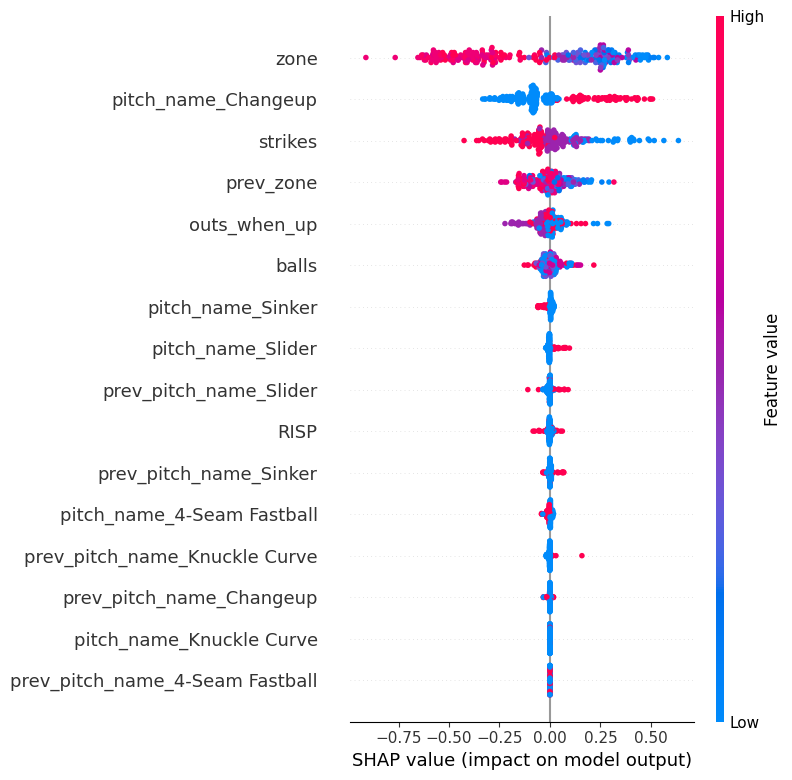

In [179]:
# Explain model predictions using SHAP
explainer = shap.Explainer(model)
shap_values = explainer(X_test)

# Summary plot
shap.summary_plot(shap_values, X_test)


In [188]:
# Example scenario: A specific previous pitch, count, and zone
example_input = pd.DataFrame({
    'prev_pitch_name_4-Seam Fastball': [1],
    'pitch_name_Slider': [1],
    'outs_when_up': [1],
    'prev_zone': [7],
    'zone': [7],
    'balls': [1],
    'strikes': [2],
    'RISP': [0]
})

# Align with training features
example_input = example_input.reindex(columns=X_train.columns, fill_value=0)

# Predict whiff probability
predicted_whiff_prob = model.predict_proba(example_input)[:, 1]
print("Predicted Whiff / Called Strike Probability:", predicted_whiff_prob)


Predicted Whiff / Called Strike Probability: [0.34506327]


In [189]:
def recommend_best_pitches(model, fixed_features, candidate_pitch_types, candidate_zones, expected_features):
    """
    Generate candidate pitch options, predict whiff probability for each,
    and return the top 10 recommendations.
    """
    recommendations = []

    for pitch in candidate_pitch_types:
        for zone in candidate_zones:
            candidate_features = fixed_features.copy()
            candidate_features.update({'pitch_name': pitch, 'zone': zone})

            candidate_df = pd.DataFrame([candidate_features])

            # One-hot encode categorical features
            candidate_df = pd.get_dummies(candidate_df, columns=['prev_pitch_name', 'pitch_name'])

            # Ensure all expected features are present (fill missing with 0)
            candidate_df = candidate_df.reindex(columns=expected_features, fill_value=0)

            # Predict the whiff probability
            whiff_prob = model.predict_proba(candidate_df)[:, 1][0]

            recommendations.append({'pitch_name': pitch, 'zone': zone, 'whiff_prob': whiff_prob})

    recs_df = pd.DataFrame(recommendations).sort_values(by='whiff_prob', ascending=False).head(10)

    return recs_df

In [194]:
# Example Usage:
# Get expected feature names from the model
expected_features = model.get_booster().feature_names

# Define fixed features, pitch types, and zones
fixed_features = {
    'prev_pitch_name': '4-Seam Fastball',
    'prev_zone': 5,
    'outs_when_up': 1,
    'balls': 1,
    'strikes': 2,
    'RISP': 0
}

candidate_pitch_types = ['Changeup', 'Sinker', '4-Seam Fastball', 'Slider', 'Knuckle Curve']
candidate_zones = list((1, 2, 3, 4, 5, 6, 7, 8, 9, 11, 12, 13, 14))  # Zones 1 to 14

# Get top recommendations
recommend_best_pitches(model, fixed_features, candidate_pitch_types, candidate_zones, expected_features).reset_index(drop=True)

,pitch_name,zone,whiff_prob
0,Changeup,14,0.392755
1,Slider,9,0.334853
2,Slider,8,0.334853
3,Slider,7,0.334853
4,Knuckle Curve,7,0.304194
5,Sinker,9,0.304194
6,Sinker,8,0.304194
7,Sinker,7,0.304194
8,4-Seam Fastball,8,0.304194
9,4-Seam Fastball,7,0.304194


## Generalize for any specified pitcher and side of the plate the batter is standing on.

In [195]:
def run_model(df, player_name, stand):

  # Filter the DataFrame for the specified player_name and stand
  filtered_df = df[(df['player_name'] == player_name) & (df['stand'] == stand)].drop(columns=['player_name', 'stand'])

  X = filtered_df.drop(columns=['WHIFF / Called Strike'])  # Everything except the target
  y = filtered_df['WHIFF / Called Strike']  # Target variable (1 for whiff, 0 for contact)

  # Split data: 70% train, 15% validation, 15% test
  X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
  X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

# Combine datasets before one-hot encoding to ensure consistency
  X_full = pd.concat([X_train, X_val, X_test])
  X_full = pd.get_dummies(X_full, columns=['prev_pitch_name', 'pitch_name']).astype('int')

  # Ensure all datasets contain the same columns after encoding
  X_train = X_full.iloc[:len(X_train)]
  X_val = X_full.iloc[len(X_train):len(X_train) + len(X_val)]
  X_test = X_full.iloc[len(X_train) + len(X_val):]

  # Initialize XGBoost classifier
  global model
  model = xgb.XGBClassifier(
      objective='binary:logistic',  # Output probabilities
      eval_metric='logloss',        # Good for probability calibration
      use_label_encoder=False,
      n_estimators=100,
      learning_rate=0.1,
      max_depth=5,
      random_state=42,
      early_stopping_rounds=10
  )

  # Train the model
  model.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=False)

  # Predict probabilities on test set
  y_pred_proba = model.predict_proba(X_test)[:, 1]  # Probability of whiff

  # Log loss (lower is better)
  print("Log Loss:", log_loss(y_test, y_pred_proba))

  # ROC-AUC (higher is better)
  print("ROC-AUC:", roc_auc_score(y_test, y_pred_proba))

  # Brier Score (lower is better, measures probability calibration)
  print("Brier Score:", brier_score_loss(y_test, y_pred_proba))

  # Explain model predictions using SHAP
  explainer = shap.Explainer(model)
  shap_values = explainer(X_test)

  # Summary plot
  shap.summary_plot(shap_values, X_test)

  return model, filtered_df  # Return both the trained model and the filtered DataFrame

Log Loss: 0.48903733544495104
ROC-AUC: 0.783178500331785
Brier Score: 0.15796725782561233


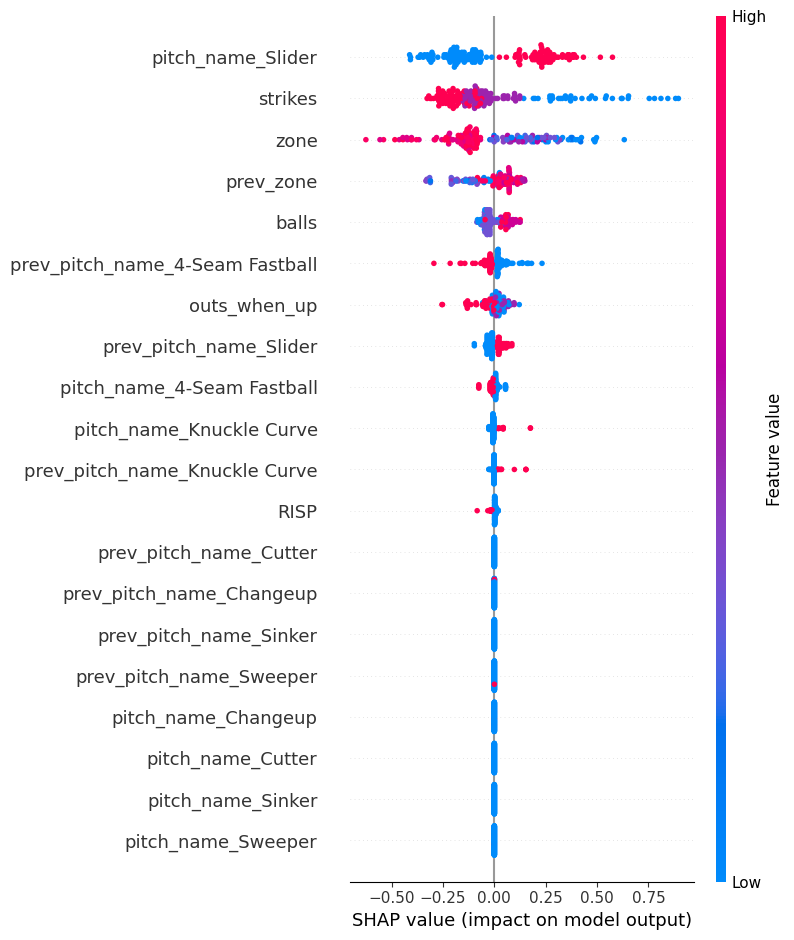

In [196]:
model, player_df = run_model(df_features, 'Cease, Dylan', 'L')

In [199]:
# Example Usage:
# Get expected feature names from the model
expected_features = model.get_booster().feature_names

# Define fixed features, pitch types, and zones
fixed_features = {
    'prev_pitch_name': '4-Seam Fastball',
    'prev_zone': 5,
    'outs_when_up': 1,
    'balls': 2,
    'strikes': 2,
    'RISP': 1
}

candidate_pitch_types = player_df['pitch_name'].unique()
candidate_zones = list((1, 2, 3, 4, 5, 6, 7, 8, 9, 11, 12, 13, 14))  # Zones 1 to 14

# Get top recommendations
recommend_best_pitches(model, fixed_features, candidate_pitch_types, candidate_zones, expected_features).reset_index(drop=True)

,pitch_name,zone,whiff_prob
0,Slider,1,0.485959
1,Slider,2,0.485959
2,Cutter,8,0.242573
3,Changeup,8,0.242573
4,Changeup,9,0.242573
5,Knuckle Curve,6,0.242573
6,Knuckle Curve,8,0.242573
7,Knuckle Curve,9,0.242573
8,Cutter,6,0.242573
9,Cutter,7,0.242573
